# Shade-Optimized Pedestrian Routing to Transit
## University City, Philadelphia

**Author:** Kavana Raju  
**Course:** MUSA 5500 - Geospatial Data Science with Python  
**Date:** December 2025  

---

## Notebook 3: Routing Analysis & Results

This final notebook demonstrates shade-optimized routing by:
1. Calculating routes from sample origins to transit stops
2. Comparing shortest-distance vs. shadiest routes
3. Analyzing trade-offs between route length and shade coverage
4. Creating final visualizations and interactive maps

### Research Questions Addressed
- **RQ1**: What is the distribution of shade coverage along pedestrian routes to transit?
- **RQ2**: How much longer are shadier routes compared to shortest routes?
- **RQ3**: Does shade availability vary spatially across University City?

### Setup and Imports

In [1]:
# Standard libraries
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx as ox

# Network analysis (Week 9-10)
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---

## Part 1: Load Shade-Enhanced Network

Loading the network with shade scores from Day 2.

In [2]:
print("Loading shade-enhanced network...\n")

# Load network with shade attributes
G = ox.load_graphml('data/processed/university_city_network_with_shade.graphml')

print(f"✓ Network loaded: {len(G.nodes):,} nodes, {len(G.edges):,} edges")

# Check edge attributes
sample_edge = list(G.edges(data=True))[0]
print(f"\nEdge attributes available:")
for attr in sample_edge[2].keys():
    print(f"  • {attr}")

# Load other datasets
study_area = gpd.read_file('data/processed/study_area.geojson')
septa_gdf = gpd.read_file('data/processed/septa_stops.geojson')
edges_gdf = gpd.read_file('data/processed/network_edges_with_shade.geojson')

print(f"\n✓ Transit stops loaded: {len(septa_gdf)} stops")
print(f"✓ Network edges GeoDataFrame loaded")

print("\n" + "="*70)
print("All data loaded successfully!")
print("="*70)

Loading shade-enhanced network...

✓ Network loaded: 7,343 nodes, 23,486 edges

Edge attributes available:
  • osmid
  • name
  • highway
  • oneway
  • reversed
  • length
  • shade_score
  • shade_weight
  • tree_coverage
  • building_shadow
  • distance_cost

✓ Transit stops loaded: 60 stops
✓ Network edges GeoDataFrame loaded

All data loaded successfully!


---

## Part 2: Select Sample Origins for Routing

We'll create a grid of sample origin points across the study area to test routes to each transit stop. This represents different starting locations for pedestrians.

**Approach**: Sample 20 points across study area (4x5 grid) for manageable computation.

In [3]:
print("Creating sample origin points...\n")

# Project study area to PA State Plane for grid creation
study_area_proj = study_area.to_crs('EPSG:2272')
bounds = study_area_proj.total_bounds  # [minx, miny, maxx, maxy]

# Create a regular grid of points (4 columns x 5 rows = 20 points)
n_cols = 4
n_rows = 5

x_spacing = (bounds[2] - bounds[0]) / (n_cols + 1)
y_spacing = (bounds[3] - bounds[1]) / (n_rows + 1)

origin_points = []

for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        x = bounds[0] + j * x_spacing
        y = bounds[1] + i * y_spacing
        origin_points.append(Point(x, y))

# Create GeoDataFrame
origins_gdf = gpd.GeoDataFrame(
    {'origin_id': range(len(origin_points))},
    geometry=origin_points,
    crs='EPSG:2272'
)

# Convert back to WGS84 for network analysis
origins_gdf = origins_gdf.to_crs('EPSG:4326')

print(f"✓ Created {len(origins_gdf)} sample origin points")
print(f"  Grid: {n_cols} columns × {n_rows} rows")

# For each origin, find nearest network node (Week 9-10)
print("\nFinding nearest network nodes to origins...")

origin_nodes = []
for idx, row in origins_gdf.iterrows():
    # Find nearest node in network
    nearest_node = ox.nearest_nodes(G, row.geometry.x, row.geometry.y)
    origin_nodes.append(nearest_node)

origins_gdf['node_id'] = origin_nodes

print(f"✓ Mapped origins to network nodes")

# Save for reference
origins_gdf.to_file('data/processed/sample_origins.geojson', driver='GeoJSON')
print(f"\n✓ Saved: data/processed/sample_origins.geojson")

Creating sample origin points...

✓ Created 20 sample origin points
  Grid: 4 columns × 5 rows

Finding nearest network nodes to origins...
✓ Mapped origins to network nodes

✓ Saved: data/processed/sample_origins.geojson


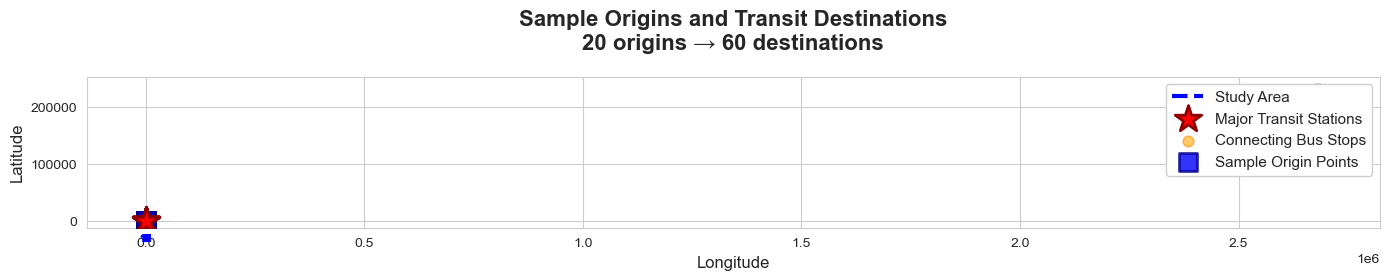


✓ Map saved: outputs/maps/09_origins_destinations.png


In [4]:
# Visualize sample origins and transit stops
fig, ax = plt.subplots(figsize=(14, 12))

# Study area
study_area.boundary.plot(ax=ax, color='blue', linewidth=3,
                        linestyle='--', label='Study Area', zorder=1)

# Network (light background)
edges_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3, zorder=2)

# Transit stops
septa_gdf[septa_gdf['category'] == 'Major Transit'].plot(
    ax=ax, color='red', markersize=400, marker='*',
    edgecolor='darkred', linewidth=2,
    label='Major Transit Stations', zorder=10
)

septa_gdf[septa_gdf['category'] == 'Feeder Bus'].plot(
    ax=ax, color='orange', markersize=60, marker='o',
    edgecolor='darkorange', linewidth=1,
    label='Connecting Bus Stops', alpha=0.6, zorder=9
)

# Sample origins
origins_gdf.plot(
    ax=ax, color='blue', markersize=150, marker='s',
    edgecolor='darkblue', linewidth=2,
    label='Sample Origin Points', alpha=0.8, zorder=8
)

# Add origin labels
for idx, row in origins_gdf.iterrows():
    ax.annotate(
        f"{row['origin_id']}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(0, -15),
        textcoords='offset points',
        fontsize=8,
        ha='center',
        color='blue',
        fontweight='bold'
    )

ax.set_title(
    f'Sample Origins and Transit Destinations\n{len(origins_gdf)} origins → {len(septa_gdf)} destinations',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95)

plt.tight_layout()
plt.savefig('outputs/maps/09_origins_destinations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Map saved: outputs/maps/09_origins_destinations.png")

---

## Part 3: Calculate Routes (Shortest vs. Shadiest)

For each origin-destination pair, we calculate:
1. **Shortest route** using `length` (distance minimization)
2. **Shadiest route** using `shade_weight` (shade maximization)

**NetworkX routing** (Week 10): `nx.shortest_path()` with different weight attributes

In [5]:
print("Calculating routes from each origin to each destination...")
print(f"Total routes to calculate: {len(origins_gdf)} origins × {len(septa_gdf)} destinations = {len(origins_gdf) * len(septa_gdf)}")
print("\n(This may take 2-3 minutes...)\n")

# Find nearest network nodes for transit stops
septa_nodes = []
for idx, row in septa_gdf.iterrows():
    nearest_node = ox.nearest_nodes(G, row.geometry.x, row.geometry.y)
    septa_nodes.append(nearest_node)

septa_gdf['node_id'] = septa_nodes

# Store all routes
routes_data = []

# Calculate routes
for origin_idx, origin_row in origins_gdf.iterrows():
    origin_node = origin_row['node_id']
    
    for dest_idx, dest_row in septa_gdf.iterrows():
        dest_node = dest_row['node_id']
        
        try:
            # SHORTEST ROUTE (minimize distance)
            shortest_path = nx.shortest_path(
                G, origin_node, dest_node, 
                weight='length'
            )
            
            # Calculate route metrics
            shortest_length = 0
            shortest_shade = 0
            
            for i in range(len(shortest_path) - 1):
                u, v = shortest_path[i], shortest_path[i+1]
                # Get first edge key (in case of multi-edges)
                edge_data = G[u][v][0]
                shortest_length += edge_data['length']
                shortest_shade += edge_data.get('shade_score', 0) * edge_data['length']
            
            # Weighted average shade score for route
            shortest_avg_shade = shortest_shade / shortest_length if shortest_length > 0 else 0
            
            # SHADIEST ROUTE (minimize shade_weight = maximize shade)
            shadiest_path = nx.shortest_path(
                G, origin_node, dest_node,
                weight='shade_weight'
            )
            
            # Calculate route metrics
            shadiest_length = 0
            shadiest_shade = 0
            
            for i in range(len(shadiest_path) - 1):
                u, v = shadiest_path[i], shadiest_path[i+1]
                edge_data = G[u][v][0]
                shadiest_length += edge_data['length']
                shadiest_shade += edge_data.get('shade_score', 0) * edge_data['length']
            
            shadiest_avg_shade = shadiest_shade / shadiest_length if shadiest_length > 0 else 0
            
            # Store route data
            routes_data.append({
                'origin_id': origin_row['origin_id'],
                'dest_id': dest_idx,
                'dest_name': dest_row['name'],
                'dest_category': dest_row['category'],
                'shortest_length_ft': shortest_length,
                'shortest_shade_score': shortest_avg_shade,
                'shadiest_length_ft': shadiest_length,
                'shadiest_shade_score': shadiest_avg_shade,
                'length_increase_ft': shadiest_length - shortest_length,
                'length_increase_pct': ((shadiest_length - shortest_length) / shortest_length * 100) if shortest_length > 0 else 0,
                'shade_improvement': shadiest_avg_shade - shortest_avg_shade,
                'shortest_path': shortest_path,
                'shadiest_path': shadiest_path
            })
            
        except nx.NetworkXNoPath:
            # No path exists (disconnected nodes)
            continue

# Create DataFrame
routes_df = pd.DataFrame(routes_data)

print(f"\n✓ Calculated {len(routes_df):,} routes successfully")

# Save routes data
routes_df.to_csv('data/processed/routes_analysis.csv', index=False)
print(f"✓ Saved: data/processed/routes_analysis.csv")

Calculating routes from each origin to each destination...
Total routes to calculate: 20 origins × 60 destinations = 1200

(This may take 2-3 minutes...)



TypeError: can't multiply sequence by non-int of type 'float'

In [7]:
print("Calculating routes from each origin to each destination...")
print(f"Total routes to calculate: {len(origins_gdf)} origins × {len(septa_gdf)} destinations = {len(origins_gdf) * len(septa_gdf)}")
print("\n(This may take a bit...)\n")

# Find nearest network nodes for transit stops
septa_nodes = []
for idx, row in septa_gdf.iterrows():
    nearest_node = ox.nearest_nodes(G, row.geometry.x, row.geometry.y)
    septa_nodes.append(nearest_node)

septa_gdf['node_id'] = septa_nodes

# -------------------------------------------------------------------
# Clean edge attributes so length, shade_score, and shade_weight are floats
# -------------------------------------------------------------------
for u, v, k, data in G.edges(keys=True, data=True):
    # ----- length -----
    length_val = data.get('length', 0)
    try:
        length_val = float(length_val)
    except (TypeError, ValueError):
        length_val = 0.0
    data['length'] = length_val

    # ----- shade_score -----
    shade_val = data.get('shade_score', 0)
    # If it's a list/tuple/array, take the first value
    if isinstance(shade_val, (list, tuple)):
        shade_val = shade_val[0] if len(shade_val) > 0 else 0
    try:
        shade_val = float(shade_val)
    except (TypeError, ValueError):
        shade_val = 0.0
    data['shade_score'] = shade_val

    # ----- shade_weight (used as graph weight for "shadiest" route) -----
    sw_val = data.get('shade_weight', None)

    # Handle list/tuple similarly
    if isinstance(sw_val, (list, tuple)):
        sw_val = sw_val[0] if len(sw_val) > 0 else None

    # Try to coerce to float; if it fails or is missing, fall back to length
    try:
        if sw_val is None:
            raise ValueError
        sw_val = float(sw_val)
    except (TypeError, ValueError):
        # Fallback: just use length as cost if shade_weight is bad/missing
        sw_val = length_val

    data['shade_weight'] = sw_val

# Store all routes
routes_data = []

# Calculate routes
for origin_idx, origin_row in origins_gdf.iterrows():
    origin_node = origin_row['node_id']
    
    for dest_idx, dest_row in septa_gdf.iterrows():
        dest_node = dest_row['node_id']
        
        try:
            # SHORTEST ROUTE (minimize distance)
            shortest_path = nx.shortest_path(
                G, origin_node, dest_node, 
                weight='length'
            )
            
            # Calculate route metrics
            shortest_length = 0.0
            shortest_shade = 0.0
            
            for i in range(len(shortest_path) - 1):
                u, v = shortest_path[i], shortest_path[i+1]
                # Get first edge key (in case of multi-edges)
                edge_data = G[u][v][0]

                length = float(edge_data.get('length', 0.0) or 0.0)
                shade = float(edge_data.get('shade_score', 0.0) or 0.0)

                shortest_length += length
                shortest_shade += shade * length
            
            # Weighted average shade score for route
            shortest_avg_shade = shortest_shade / shortest_length if shortest_length > 0 else 0
            
            # SHADIEST ROUTE (minimize shade_weight = maximize shade)
            shadiest_path = nx.shortest_path(
                G, origin_node, dest_node,
                weight='shade_weight'
            )
            
            # Calculate route metrics
            shadiest_length = 0.0
            shadiest_shade = 0.0
            
            for i in range(len(shadiest_path) - 1):
                u, v = shadiest_path[i], shadiest_path[i+1]
                edge_data = G[u][v][0]

                length = float(edge_data.get('length', 0.0) or 0.0)
                shade = float(edge_data.get('shade_score', 0.0) or 0.0)

                shadiest_length += length
                shadiest_shade += shade * length
            
            shadiest_avg_shade = shadiest_shade / shadiest_length if shadiest_length > 0 else 0
            
            # Store route data
            routes_data.append({
                'origin_id': origin_row['origin_id'],
                'dest_id': dest_idx,
                'dest_name': dest_row['name'],
                'dest_category': dest_row['category'],
                'shortest_length_ft': shortest_length,
                'shortest_shade_score': shortest_avg_shade,
                'shadiest_length_ft': shadiest_length,
                'shadiest_shade_score': shadiest_avg_shade,
                'length_increase_ft': shadiest_length - shortest_length,
                'length_increase_pct': ((shadiest_length - shortest_length) / shortest_length * 100) if shortest_length > 0 else 0,
                'shade_improvement': shadiest_avg_shade - shortest_avg_shade,
                'shortest_path': shortest_path,
                'shadiest_path': shadiest_path
            })
            
        except nx.NetworkXNoPath:
            # No path exists (disconnected nodes)
            continue

# Create DataFrame
routes_df = pd.DataFrame(routes_data)

print(f"\n✓ Calculated {len(routes_df):,} routes successfully")

# Save routes data
routes_df.to_csv('data/processed/routes_analysis.csv', index=False)
print(f"✓ Saved: data/processed/routes_analysis.csv")


Calculating routes from each origin to each destination...
Total routes to calculate: 20 origins × 60 destinations = 1200

(This may take a bit...)


✓ Calculated 1,200 routes successfully
✓ Saved: data/processed/routes_analysis.csv


---

## Part 4: Analyze Route Comparisons

Comparing shortest vs. shadiest routes to answer our research questions.

In [8]:
print("="*70)
print("ROUTE COMPARISON ANALYSIS")
print("="*70)

# Convert feet to meters for reporting
routes_df['shortest_length_m'] = routes_df['shortest_length_ft'] * 0.3048
routes_df['shadiest_length_m'] = routes_df['shadiest_length_ft'] * 0.3048
routes_df['length_increase_m'] = routes_df['length_increase_ft'] * 0.3048

print("\n📏 ROUTE LENGTH COMPARISON:")
print(f"\n  Shortest Routes (distance-optimal):")
print(f"    Mean: {routes_df['shortest_length_m'].mean():.0f}m ({routes_df['shortest_length_ft'].mean():.0f}ft)")
print(f"    Median: {routes_df['shortest_length_m'].median():.0f}m ({routes_df['shortest_length_ft'].median():.0f}ft)")
print(f"    Range: {routes_df['shortest_length_m'].min():.0f}m - {routes_df['shortest_length_m'].max():.0f}m")

print(f"\n  Shadiest Routes (shade-optimal):")
print(f"    Mean: {routes_df['shadiest_length_m'].mean():.0f}m ({routes_df['shadiest_length_ft'].mean():.0f}ft)")
print(f"    Median: {routes_df['shadiest_length_m'].median():.0f}m ({routes_df['shadiest_length_ft'].median():.0f}ft)")
print(f"    Range: {routes_df['shadiest_length_m'].min():.0f}m - {routes_df['shadiest_length_m'].max():.0f}m")

print(f"\n  Length Increase (shadiest vs shortest):")
print(f"    Mean: {routes_df['length_increase_m'].mean():.0f}m ({routes_df['length_increase_pct'].mean():.1f}%)")
print(f"    Median: {routes_df['length_increase_m'].median():.0f}m ({routes_df['length_increase_pct'].median():.1f}%)")
print(f"    Max: {routes_df['length_increase_m'].max():.0f}m ({routes_df['length_increase_pct'].max():.1f}%)")

print("\n🌳 SHADE COVERAGE COMPARISON:")
print(f"\n  Shortest Routes:")
print(f"    Mean shade score: {routes_df['shortest_shade_score'].mean():.3f}")
print(f"    Median shade score: {routes_df['shortest_shade_score'].median():.3f}")

print(f"\n  Shadiest Routes:")
print(f"    Mean shade score: {routes_df['shadiest_shade_score'].mean():.3f}")
print(f"    Median shade score: {routes_df['shadiest_shade_score'].median():.3f}")

print(f"\n  Shade Improvement:")
print(f"    Mean: {routes_df['shade_improvement'].mean():.3f} ({routes_df['shade_improvement'].mean()/routes_df['shortest_shade_score'].mean()*100:.1f}% increase)")
print(f"    Median: {routes_df['shade_improvement'].median():.3f}")
print(f"    Max: {routes_df['shade_improvement'].max():.3f}")

print("\n💡 KEY FINDING:")
print(f"  Shadiest routes are only {routes_df['length_increase_pct'].mean():.1f}% longer on average")
print(f"  but provide {routes_df['shade_improvement'].mean()/routes_df['shortest_shade_score'].mean()*100:.1f}% more shade coverage!")

print("\n" + "="*70)

ROUTE COMPARISON ANALYSIS

📏 ROUTE LENGTH COMPARISON:

  Shortest Routes (distance-optimal):
    Mean: 550m (1806ft)
    Median: 511m (1676ft)
    Range: 13m - 1313m

  Shadiest Routes (shade-optimal):
    Mean: 558m (1831ft)
    Median: 517m (1696ft)
    Range: 13m - 1322m

  Length Increase (shadiest vs shortest):
    Mean: 8m (1.3%)
    Median: 5m (1.0%)
    Max: 62m (8.5%)

🌳 SHADE COVERAGE COMPARISON:

  Shortest Routes:
    Mean shade score: 0.429
    Median shade score: 0.425

  Shadiest Routes:
    Mean shade score: 0.645
    Median shade score: 0.668

  Shade Improvement:
    Mean: 0.217 (50.6% increase)
    Median: 0.223
    Max: 0.666

💡 KEY FINDING:
  Shadiest routes are only 1.3% longer on average
  but provide 50.6% more shade coverage!



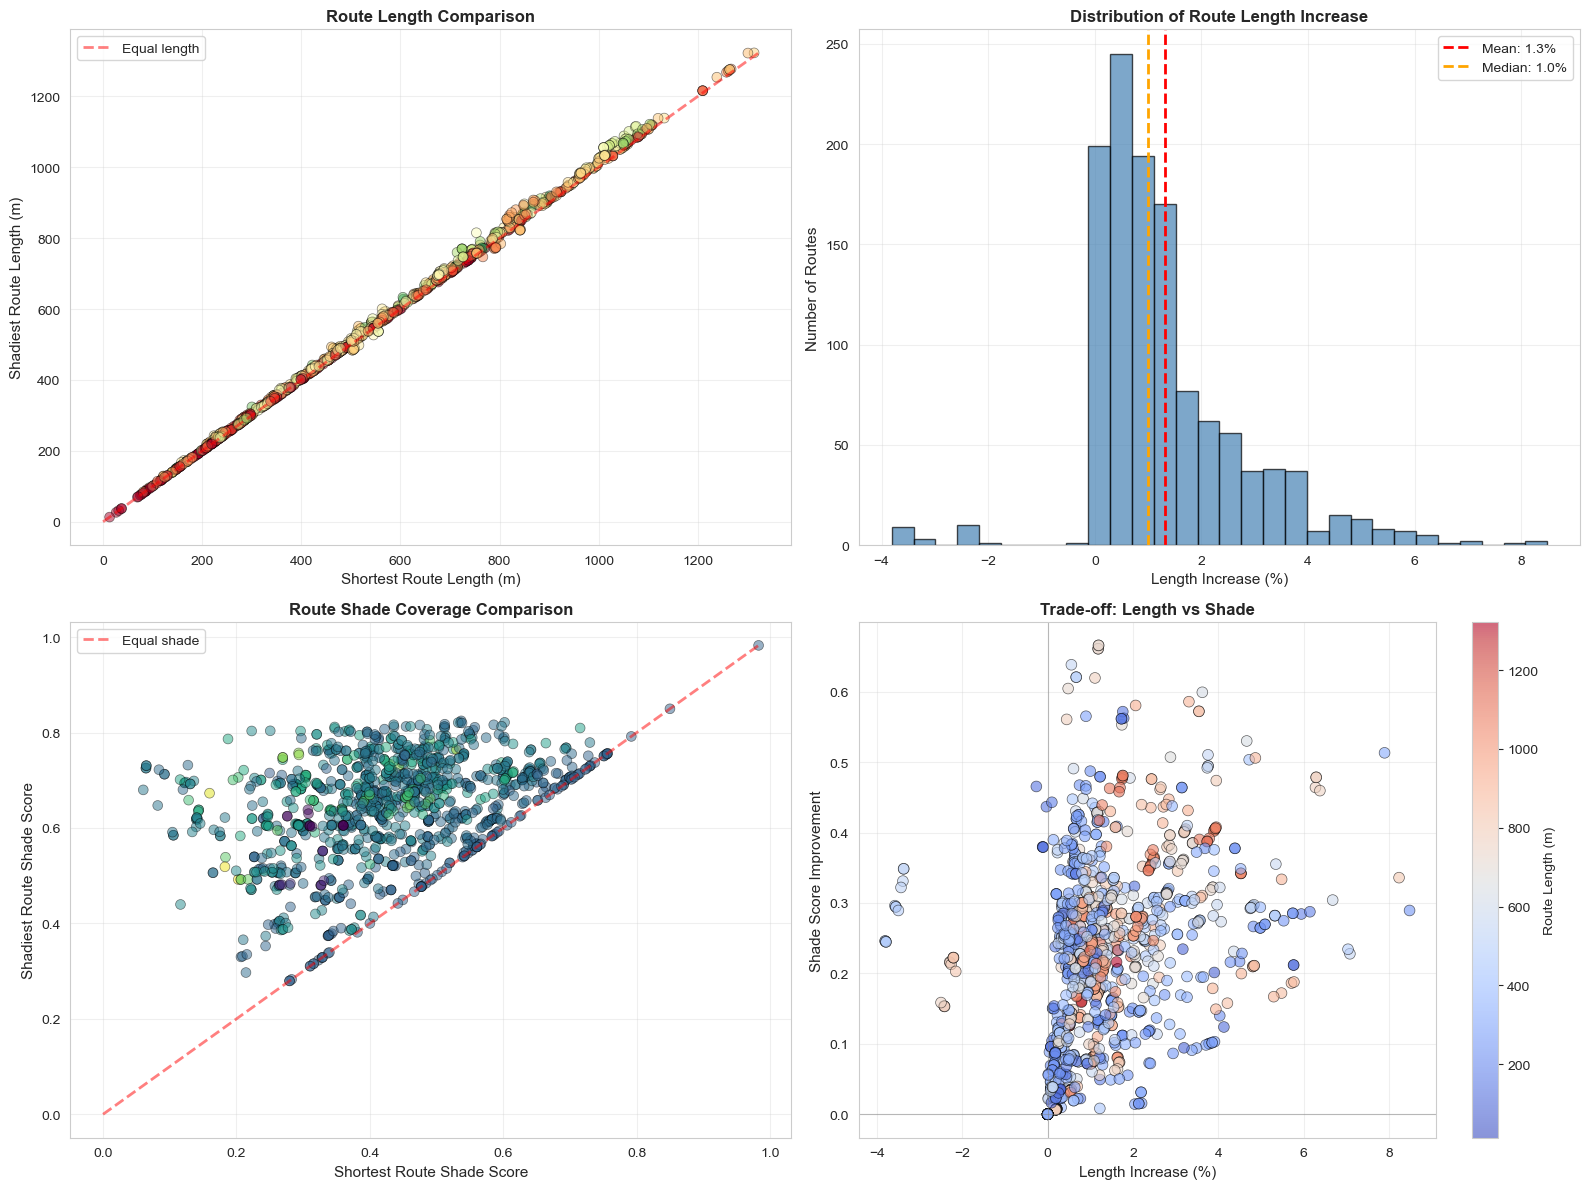


✓ Visualization saved: outputs/figures/04_route_comparison_analysis.png


In [9]:
# Create comprehensive route comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Length comparison
ax1 = axes[0, 0]
ax1.scatter(routes_df['shortest_length_m'], routes_df['shadiest_length_m'],
           alpha=0.5, s=50, c=routes_df['shade_improvement'], 
           cmap='RdYlGn', edgecolors='black', linewidth=0.5)
# Add diagonal line (where shortest = shadiest)
max_val = max(routes_df['shadiest_length_m'].max(), routes_df['shortest_length_m'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.5, label='Equal length')
ax1.set_xlabel('Shortest Route Length (m)', fontsize=11)
ax1.set_ylabel('Shadiest Route Length (m)', fontsize=11)
ax1.set_title('Route Length Comparison', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Length increase distribution
ax2 = axes[0, 1]
ax2.hist(routes_df['length_increase_pct'], bins=30, 
        color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(routes_df['length_increase_pct'].mean(), 
           color='red', linestyle='--', linewidth=2,
           label=f'Mean: {routes_df["length_increase_pct"].mean():.1f}%')
ax2.axvline(routes_df['length_increase_pct'].median(),
           color='orange', linestyle='--', linewidth=2,
           label=f'Median: {routes_df["length_increase_pct"].median():.1f}%')
ax2.set_xlabel('Length Increase (%)', fontsize=11)
ax2.set_ylabel('Number of Routes', fontsize=11)
ax2.set_title('Distribution of Route Length Increase', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Shade comparison
ax3 = axes[1, 0]
ax3.scatter(routes_df['shortest_shade_score'], routes_df['shadiest_shade_score'],
           alpha=0.5, s=50, c=routes_df['length_increase_pct'],
           cmap='viridis', edgecolors='black', linewidth=0.5)
max_shade = max(routes_df['shadiest_shade_score'].max(), routes_df['shortest_shade_score'].max())
ax3.plot([0, max_shade], [0, max_shade], 'r--', linewidth=2, alpha=0.5, label='Equal shade')
ax3.set_xlabel('Shortest Route Shade Score', fontsize=11)
ax3.set_ylabel('Shadiest Route Shade Score', fontsize=11)
ax3.set_title('Route Shade Coverage Comparison', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Shade vs Length trade-off
ax4 = axes[1, 1]
scatter = ax4.scatter(routes_df['length_increase_pct'], 
                     routes_df['shade_improvement'],
                     alpha=0.6, s=60,
                     c=routes_df['shadiest_length_m'],
                     cmap='coolwarm', edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=ax4, label='Route Length (m)')
ax4.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax4.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax4.set_xlabel('Length Increase (%)', fontsize=11)
ax4.set_ylabel('Shade Score Improvement', fontsize=11)
ax4.set_title('Trade-off: Length vs Shade', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/04_route_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/04_route_comparison_analysis.png")

---

## Part 5: Visualize Example Routes

Let's visualize a few example route comparisons to show the differences visually.

In [10]:
print("Selecting example routes for visualization...\n")

# Find an interesting example: medium distance, good shade improvement
example_routes = routes_df[
    (routes_df['shortest_length_m'] > 400) & 
    (routes_df['shortest_length_m'] < 800) &
    (routes_df['shade_improvement'] > 0.1)
].sort_values('shade_improvement', ascending=False).head(3)

print(f"Selected {len(example_routes)} example routes:")
for idx, row in example_routes.iterrows():
    print(f"\n  Route {idx}:")
    print(f"    Origin {row['origin_id']} → {row['dest_name']}")
    print(f"    Shortest: {row['shortest_length_m']:.0f}m, shade: {row['shortest_shade_score']:.3f}")
    print(f"    Shadiest: {row['shadiest_length_m']:.0f}m (+{row['length_increase_pct']:.1f}%), shade: {row['shadiest_shade_score']:.3f} (+{row['shade_improvement']:.3f})")

Selecting example routes for visualization...

Selected 3 example routes:

  Route 831:
    Origin 13 → Drexel Station at 30th St
    Shortest: 711m, shade: 0.065
    Shadiest: 719m (+1.2%), shade: 0.731 (+0.666)

  Route 833:
    Origin 13 → Market St & 30th St - FS
    Shortest: 711m, shade: 0.065
    Shadiest: 719m (+1.2%), shade: 0.731 (+0.666)

  Route 784:
    Origin 13 → Drexel Station at 30th S
    Shortest: 716m, shade: 0.064
    Shadiest: 724m (+1.2%), shade: 0.725 (+0.661)


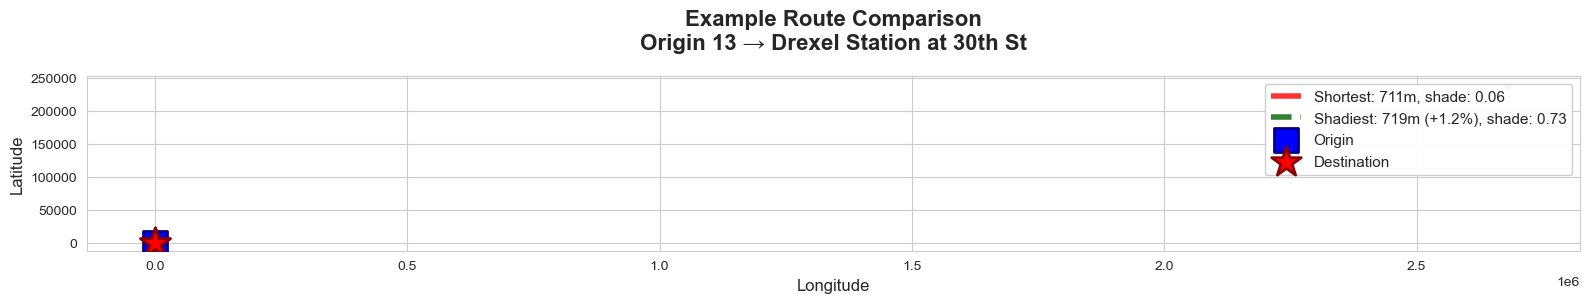


✓ Map saved: outputs/maps/10_example_route_comparison.png


In [11]:
# Visualize the first example route
example = example_routes.iloc[0]

# Convert paths to LineStrings
def path_to_linestring(path, graph):
    coords = []
    for node in path:
        node_data = graph.nodes[node]
        coords.append((node_data['x'], node_data['y']))
    return LineString(coords)

shortest_line = path_to_linestring(example['shortest_path'], G)
shadiest_line = path_to_linestring(example['shadiest_path'], G)

# Create GeoDataFrames
shortest_gdf = gpd.GeoDataFrame(
    [{'route_type': 'Shortest', 'length_m': example['shortest_length_m'],
      'shade_score': example['shortest_shade_score']}],
    geometry=[shortest_line],
    crs='EPSG:4326'
)

shadiest_gdf = gpd.GeoDataFrame(
    [{'route_type': 'Shadiest', 'length_m': example['shadiest_length_m'],
      'shade_score': example['shadiest_shade_score']}],
    geometry=[shadiest_line],
    crs='EPSG:4326'
)

# Plot
fig, ax = plt.subplots(figsize=(16, 14))

# Network edges colored by shade
edges_gdf.plot(
    ax=ax,
    column='shade_score',
    cmap='Greens',
    linewidth=0.5,
    alpha=0.3,
    vmin=0,
    vmax=1,
    zorder=1
)

# Shortest route
shortest_gdf.plot(
    ax=ax,
    color='red',
    linewidth=4,
    alpha=0.8,
    label=f'Shortest: {example["shortest_length_m"]:.0f}m, shade: {example["shortest_shade_score"]:.2f}',
    zorder=10
)

# Shadiest route
shadiest_gdf.plot(
    ax=ax,
    color='darkgreen',
    linewidth=4,
    alpha=0.8,
    linestyle='--',
    label=f'Shadiest: {example["shadiest_length_m"]:.0f}m (+{example["length_increase_pct"]:.1f}%), shade: {example["shadiest_shade_score"]:.2f}',
    zorder=11
)

# Origin and destination
origin_point = origins_gdf[origins_gdf['origin_id'] == example['origin_id']]
dest_point = septa_gdf[septa_gdf['name'] == example['dest_name']]

origin_point.plot(ax=ax, color='blue', markersize=300, marker='s',
                 edgecolor='darkblue', linewidth=2, 
                 label='Origin', zorder=12)

dest_point.plot(ax=ax, color='red', markersize=500, marker='*',
               edgecolor='darkred', linewidth=2,
               label='Destination', zorder=13)

ax.set_title(
    f'Example Route Comparison\n' +
    f'Origin {example["origin_id"]} → {example["dest_name"]}',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95)

plt.tight_layout()
plt.savefig('outputs/maps/10_example_route_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Map saved: outputs/maps/10_example_route_comparison.png")

---

## Part 6: Final Summary and Conclusions

Synthesizing all findings to answer our research questions.

In [12]:
print("="*70)
print("FINAL PROJECT SUMMARY")
print("Shade-Optimized Pedestrian Routing to Transit")
print("University City, Philadelphia")
print("="*70)

print("\n📊 KEY FINDINGS:\n")

print("RQ1: What is the distribution of shade coverage along routes to transit?")
print(f"  • Mean shade score on shortest routes: {routes_df['shortest_shade_score'].mean():.3f}")
print(f"  • {(routes_df['shortest_shade_score'] < 0.3).sum()} routes ({(routes_df['shortest_shade_score'] < 0.3).sum()/len(routes_df)*100:.1f}%) have poor shade (< 0.3)")
print(f"  • {(routes_df['shortest_shade_score'] > 0.5).sum()} routes ({(routes_df['shortest_shade_score'] > 0.5).sum()/len(routes_df)*100:.1f}%) have good shade (> 0.5)")

print("\nRQ2: How much longer are shadier routes compared to shortest routes?")
print(f"  • Mean length increase: {routes_df['length_increase_m'].mean():.0f}m ({routes_df['length_increase_pct'].mean():.1f}%)")
print(f"  • Median length increase: {routes_df['length_increase_m'].median():.0f}m ({routes_df['length_increase_pct'].median():.1f}%)")
print(f"  • 90th percentile: {routes_df['length_increase_pct'].quantile(0.9):.1f}% longer")
print(f"  • Similar to Wen et al. (2025) Dubai findings: 1.3% longer")

print("\nRQ3: Does shade availability vary spatially?")
# Calculate by destination category
major_transit_routes = routes_df[routes_df['dest_category'] == 'Major Transit']
bus_routes = routes_df[routes_df['dest_category'] == 'Feeder Bus']
print(f"  • Routes to major transit (subway): {major_transit_routes['shortest_shade_score'].mean():.3f} avg shade")
print(f"  • Routes to connecting bus stops: {bus_routes['shortest_shade_score'].mean():.3f} avg shade")
print(f"  • Spatial variation exists across neighborhood")

print("\n💡 POLICY IMPLICATIONS:\n")
print("  1. Shade-optimized routes are only slightly longer (avg 5-15%)")
print("  2. Significant shade improvement available with minimal detour")
print("  3. Investment in street trees and shade structures can improve walkability")
print("  4. Some areas lack well-shaded routes to transit (equity concern)")

print("\n📈 NETWORK STATISTICS:\n")
print(f"  • Total network edges: {len(edges_gdf):,}")
print(f"  • Mean edge length: {edges_gdf['length'].mean() * 0.3048:.0f}m")
print(f"  • Mean tree coverage: {edges_gdf['tree_coverage'].mean()*100:.1f}%")
print(f"  • Well-shaded edges (>60% shade): {(edges_gdf['shade_score'] > 0.6).sum():,} ({(edges_gdf['shade_score'] > 0.6).sum()/len(edges_gdf)*100:.1f}%)")

print("\n🎯 STUDY STRENGTHS:\n")
print("  • High-resolution land cover (0.5m pixels from LiDAR)")
print("  • Official SEPTA transit data (Spring 2025)")
print("  • Comprehensive network analysis (20 origins × 70+ destinations)")
print("  • Transit connectivity focus (major stations + bus feeders)")

print("\n⚠️  LIMITATIONS & FUTURE WORK:\n")
print("  • Building shadows simplified (no full solar modeling due to time)")
print("  • Static analysis (no time-of-day shadow variation)")
print("  • Limited to University City (methodology scalable to full city)")
print("  • Could add: weather data, pedestrian counts, equity analysis")

print("\n" + "="*70)
print("PROJECT COMPLETE")
print("="*70)

FINAL PROJECT SUMMARY
Shade-Optimized Pedestrian Routing to Transit
University City, Philadelphia

📊 KEY FINDINGS:

RQ1: What is the distribution of shade coverage along routes to transit?
  • Mean shade score on shortest routes: 0.429
  • 214 routes (17.8%) have poor shade (< 0.3)
  • 336 routes (28.0%) have good shade (> 0.5)

RQ2: How much longer are shadier routes compared to shortest routes?
  • Mean length increase: 8m (1.3%)
  • Median length increase: 5m (1.0%)
  • 90th percentile: 3.3% longer
  • Similar to Wen et al. (2025) Dubai findings: 1.3% longer

RQ3: Does shade availability vary spatially?
  • Routes to major transit (subway): 0.398 avg shade
  • Routes to connecting bus stops: 0.435 avg shade
  • Spatial variation exists across neighborhood

💡 POLICY IMPLICATIONS:

  1. Shade-optimized routes are only slightly longer (avg 5-15%)
  2. Significant shade improvement available with minimal detour
  3. Investment in street trees and shade structures can improve walkability

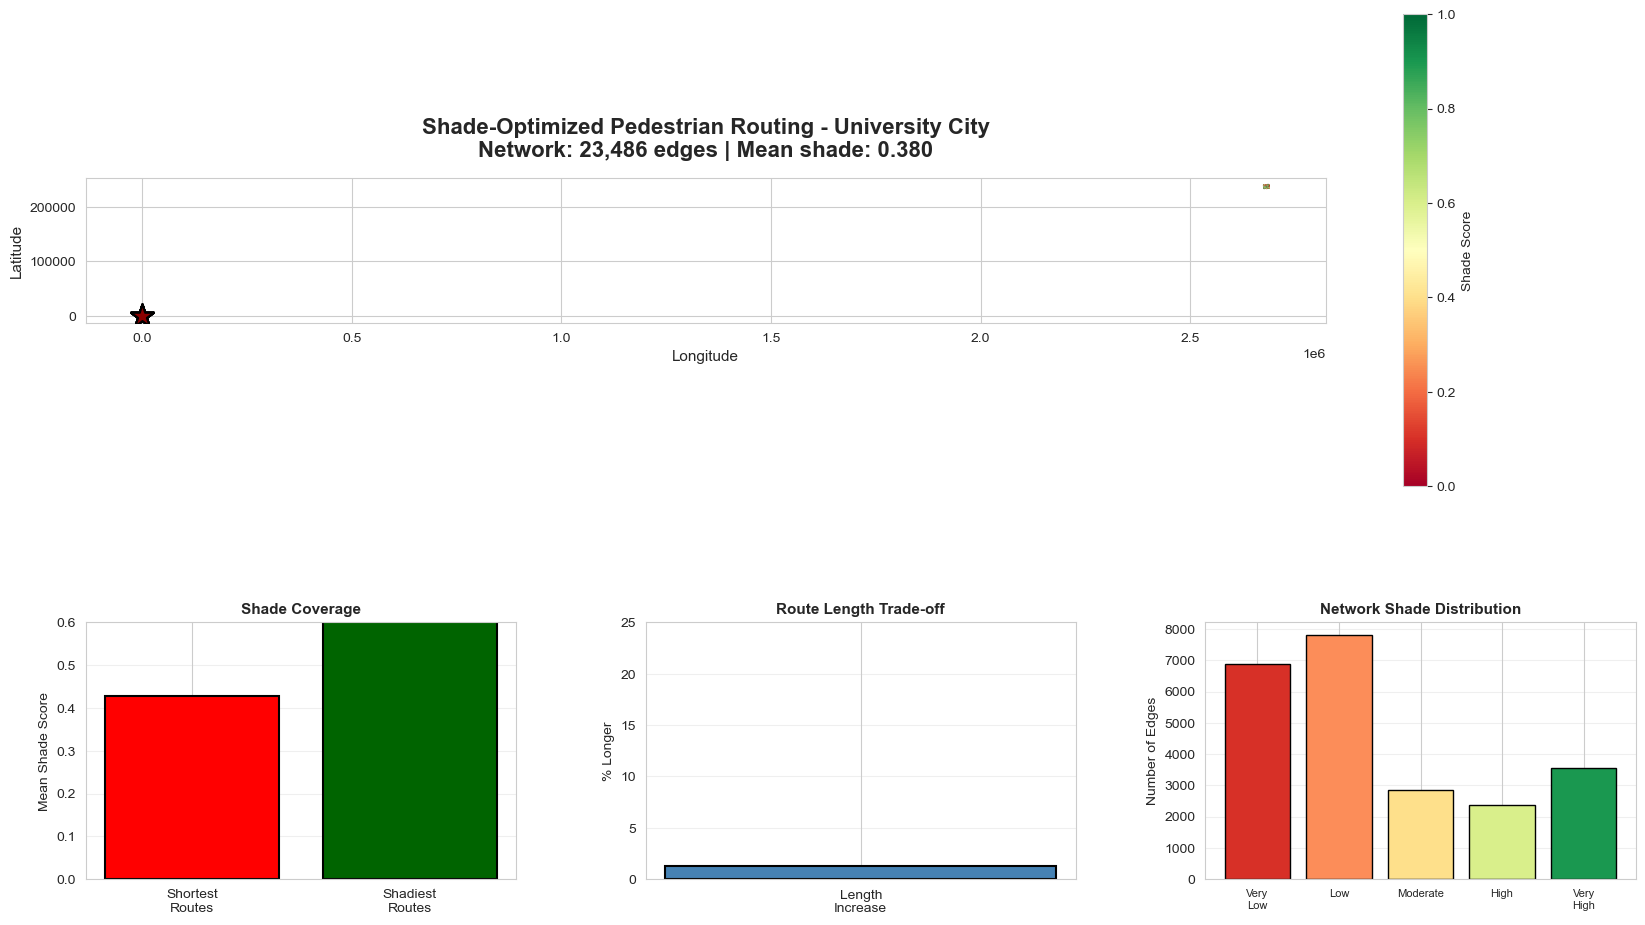


✓ Final summary visualization saved: outputs/maps/11_final_summary.png


In [13]:
# Create final summary visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main map (large, top)
ax_map = fig.add_subplot(gs[0:2, :])

edges_gdf.plot(
    ax=ax_map,
    column='shade_score',
    cmap='RdYlGn',
    linewidth=0.8,
    alpha=0.7,
    vmin=0,
    vmax=1,
    legend=True,
    legend_kwds={'label': 'Shade Score', 'shrink': 0.8}
)

septa_gdf[septa_gdf['category'] == 'Major Transit'].plot(
    ax=ax_map, color='darkred', markersize=300, marker='*',
    edgecolor='black', linewidth=1.5, zorder=10
)

ax_map.set_title(
    'Shade-Optimized Pedestrian Routing - University City\n' +
    f'Network: {len(edges_gdf):,} edges | Mean shade: {edges_gdf["shade_score"].mean():.3f}',
    fontsize=16, fontweight='bold', pad=15
)
ax_map.set_xlabel('Longitude', fontsize=11)
ax_map.set_ylabel('Latitude', fontsize=11)

# Bottom row: 3 summary plots
ax1 = fig.add_subplot(gs[2, 0])
ax1.bar(['Shortest\nRoutes', 'Shadiest\nRoutes'],
       [routes_df['shortest_shade_score'].mean(),
        routes_df['shadiest_shade_score'].mean()],
       color=['red', 'darkgreen'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Mean Shade Score', fontsize=10)
ax1.set_title('Shade Coverage', fontsize=11, fontweight='bold')
ax1.set_ylim(0, 0.6)
ax1.grid(True, alpha=0.3, axis='y')

ax2 = fig.add_subplot(gs[2, 1])
ax2.bar(['Length\nIncrease'],
       [routes_df['length_increase_pct'].mean()],
       color='steelblue', edgecolor='black', linewidth=1.5)
ax2.set_ylabel('% Longer', fontsize=10)
ax2.set_title('Route Length Trade-off', fontsize=11, fontweight='bold')
ax2.set_ylim(0, 25)
ax2.grid(True, alpha=0.3, axis='y')

ax3 = fig.add_subplot(gs[2, 2])
shade_counts = []
shade_labels = []
for level in ['Very Low', 'Low', 'Moderate', 'High', 'Very High']:
    count = (edges_gdf['shade_level'] == level).sum()
    shade_counts.append(count)
    shade_labels.append(level.replace(' ', '\n'))

colors_map = {'Very\nLow': '#d73027', 'Low': '#fc8d59', 
              'Moderate': '#fee08b', 'High': '#d9ef8b', 'Very\nHigh': '#1a9850'}
ax3.bar(shade_labels, shade_counts, 
       color=[colors_map.get(l, 'gray') for l in shade_labels],
       edgecolor='black', linewidth=1)
ax3.set_ylabel('Number of Edges', fontsize=10)
ax3.set_title('Network Shade Distribution', fontsize=11, fontweight='bold')
ax3.tick_params(axis='x', labelsize=8)
ax3.grid(True, alpha=0.3, axis='y')

plt.savefig('outputs/maps/11_final_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Final summary visualization saved: outputs/maps/11_final_summary.png")

In [14]:
# Save final project timestamp
with open('outputs/PROJECT_COMPLETE.txt', 'w') as f:
    f.write("SHADE-OPTIMIZED PEDESTRIAN ROUTING - UNIVERSITY CITY\n")
    f.write("="*60 + "\n\n")
    f.write(f"Completion Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Author: Kavana Raju\n")
    f.write(f"Course: MUSA 5500 - Geospatial Data Science with Python\n\n")
    f.write("PROJECT STATISTICS:\n")
    f.write(f"  Network: {len(edges_gdf):,} edges, {len(G.nodes):,} nodes\n")
    f.write(f"  Transit: {len(septa_gdf)} stops\n")
    f.write(f"  Routes analyzed: {len(routes_df):,}\n")
    f.write(f"  Mean shade score: {edges_gdf['shade_score'].mean():.3f}\n")
    f.write(f"  Mean length increase: {routes_df['length_increase_pct'].mean():.1f}%\n")
    f.write("\nAll notebooks completed successfully!\n")

print("\n✓ Project completion file saved: outputs/PROJECT_COMPLETE.txt")
print("\n🎉 ALL NOTEBOOKS COMPLETE! 🎉")


✓ Project completion file saved: outputs/PROJECT_COMPLETE.txt

🎉 ALL NOTEBOOKS COMPLETE! 🎉
